# Virtual Autoencoders

In [1]:
import pandas as pd
import numpy as np
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import os
from torchvision.utils import save_image
from torch.autograd import Variable
from os.path import exists
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [86]:
df = pd.read_csv('data/dataset.csv', low_memory = False).fillna(0)
df['Installation_number'] = df['Installation_number'].astype(int)
df["Date"] = df["Year"].astype(str) + "/" + df["Month"].astype(str)
df["Date"] = pd.to_datetime(df["Date"], format='%Y/%m/%d')
df.head(5)

,Year,Month,Consumer_number,Consumer_type,Installation_zone,Consumption,Installation_number,Date
0,2013,1,21018,1,4,0,0,2013-01-01
1,2013,1,36690,2,6,5,0,2013-01-01
2,2013,1,17940,1,6,6,0,2013-01-01
3,2013,1,14273,1,6,1,0,2013-01-01
4,2013,1,5,1,6,13,0,2013-01-01


In [50]:
df1 = df[df['Year'] == 2019].drop(columns={'Year', 'Installation_zone', 'Consumer_type', 'Installation_number'})
df1 = df1.drop_duplicates().fillna(0)
df1.head(5)
# len(df1)

,Month,Consumer_number,Consumption,Date
247750,1,21018,11,2019-01-01
247751,1,49120,5,2019-01-01
247752,1,17940,0,2019-01-01
247753,1,14273,1,2019-01-01
247754,1,5,8,2019-01-01


In [11]:
monthes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [12]:
df_vae = df1.groupby(['Consumer_number', 'Month'], as_index = False).sum()
df_vae = df_vae.pivot(index = 'Consumer_number', columns = 'Month', values = 'Consumption')
df_vae = df_vae.fillna(0)
df_vae = df_vae.rename_axis(None,axis=1).set_axis(monthes, inplace=False, axis=1).reset_index()
df_vae.head(5)

,Consumer_number,1,2,3,4,5,6,7,8,9,10,11,12
0,1,0.0,0.0,0.0,31.0,208.0,0.0,219.0,308.0,0.0,0.0,0.0,0.0
1,5,8.0,0.0,0.0,0.0,8.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0
2,11,2.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,2.0,0.0,0.0
3,15,6.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
4,16,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,12.0,0.0,4.0,0.0


In [13]:
df2 = df
df2 = df2[df2['Year'] == 2019].drop(columns={'Year'})
df2 = df2.drop_duplicates().fillna(0)
df2.head(5)

,Month,Consumer_number,Consumer_type,Installation_zone,Consumption,Installation_number
247750,1,21018,1,4,11,1
247751,1,49120,1,6,5,2
247752,1,17940,1,6,0,3
247753,1,14273,1,6,1,4
247754,1,5,1,6,8,5


In [14]:
df2 = df2.groupby(['Consumer_number', 'Month', 'Consumer_type'], as_index = False).sum()
df2 = df2.drop(columns=['Month', 'Consumption', 'Installation_zone'])
df2 = df2.drop_duplicates()
df2.head(5)

,Consumer_number,Consumer_type,Installation_number
0,1,3,3069
4,5,1,5
7,11,1,11
10,15,2,15
14,16,1,16


In [15]:
df_final = pd.merge(df_vae, df2, on="Consumer_number")
df_final = df_final.drop(columns = {'Consumer_number'})
df_final = df_final.loc[~df_final[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]].apply(lambda row: (row==0).all(), axis=1)]
df_final

,1,2,3,4,5,6,7,8,9,10,11,12,Consumer_type,Installation_number
0,0.0,0.0,0.0,31.0,208.0,0.0,219.0,308.0,0.0,0.0,0.0,0.0,3,3069
1,8.0,0.0,0.0,0.0,8.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,1,5
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,2.0,0.0,0.0,1,11
3,6.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2,15
4,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,12.0,0.0,4.0,0.0,1,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,29879
18838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,11099
18839,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1,3533
18844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1,7641


In [16]:
columns_to_norm = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
df_final[columns_to_norm] = df_final[columns_to_norm].apply(lambda x: x/x.max(), axis=1)

In [17]:
df_final = df_final.fillna(0)
df_final

,1,2,3,4,5,6,7,8,9,10,11,12,Consumer_type,Installation_number
0,0.000000,0.0,0.0,0.100649,0.675325,0.0,0.711039,1.0,0.0,0.000000,0.000000,0.0,3,3069
1,1.000000,0.0,0.0,0.000000,1.000000,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.0,1,5
2,0.166667,0.0,0.0,0.000000,0.000000,0.0,0.000000,1.0,0.0,0.166667,0.000000,0.0,1,11
3,0.461538,0.0,1.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.230769,0.000000,0.0,2,15
4,0.000000,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.0,0.8,0.000000,0.266667,0.0,1,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18837,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.0,1,29879
18838,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.0,1,11099
18839,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.0,1,3533
18844,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.0,1,7641


In [20]:
class MyDataset(Dataset):

  def __init__(self, df):

    x= df.iloc[:,0:12].values
    y = df.iloc[:,12:13].values
    

    self.x_train=torch.tensor(x, dtype=torch.float32)
    self.y_train=torch.tensor(y,dtype=torch.int32)

  def __len__(self):
    return len(self.x_train)
  
  def __getitem__(self,idx):
    return self.x_train[idx], self.y_train[idx]

In [21]:
myDs=MyDataset(df_final)
myDs.__getitem__(0)

(tensor([0.0000, 0.0000, 0.0000, 0.1006, 0.6753, 0.0000, 0.7110, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000]),
 tensor([3], dtype=torch.int32))

In [22]:
num_epochs = 100
batch_size = 128
learning_rate = 1e-3

# DataLoader is used to load the dataset
# for training
loader = torch.utils.data.DataLoader(dataset = myDs, batch_size = batch_size,shuffle = True)

In [23]:
# smth = next(iter(loader))
# smth

In [24]:
class VAE(torch.nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = torch.nn.Linear(12, 8)
        self.fc21 = torch.nn.Linear(8, 2)
        self.fc22 = torch.nn.Linear(8, 2)
        self.fc3 = torch.nn.Linear(2, 8)
        self.fc4 = torch.nn.Linear(8, 12)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

In [25]:
# Model Initialization
model = VAE()
#moving to gpu
if torch.cuda.is_available():
    model.cuda()
    
reconstruction_function = torch.nn.MSELoss(size_average=False)


def loss_function(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    BCE = reconstruction_function(recon_x, x)  # mse loss
    # print("BCE:", BCE)
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    # print("KLD_element:", KLD_element)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # print("KLD:", KLD)
    # KL divergence
    # print("BCE + KLD:", BCE + KLD)
    return BCE + KLD


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [26]:
model_file = "vae.pth"

In [27]:
losses = []
avg_loss = []
iteration = 0
iter_j = 0
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(loader):
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img)
        if torch.cuda.is_available():
            img = img.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(img)
        loss = loss_function(recon_batch, img, mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
        # if batch_idx % 100 == 0:
            # print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            # epoch,
            # batch_idx * len(img),
            # len(loader.dataset), 100. * batch_idx / len(loader),
            # loss.data / len(img)))
        losses.append([(loss.data / len(img)).item(), iteration])
        iteration += 1

    # print('====> Epoch: {} Average loss: {:.4f}'.format(
    #     epoch, train_loss / len(loader.dataset)))
        # if epoch % 10 == 0:
        #     save = to_img(recon_batch.cpu().data)
        #     save_image(save, './vae_img/image_{}.png'.format(epoch))
    avg_loss.append([(train_loss / len(loader.dataset)).item(), iter_j])
    iter_j += 1

    torch.save(model.state_dict(), model_file)
        
    model.eval()

In [28]:
loss = pd.DataFrame(losses, columns = ['Loss','Iteration'])
loss.head()

,Loss,Iteration
0,2.865641,0
1,2.834308,1
2,2.811957,2
3,2.861969,3
4,2.842782,4


<AxesSubplot:xlabel='Iteration', ylabel='Loss'>

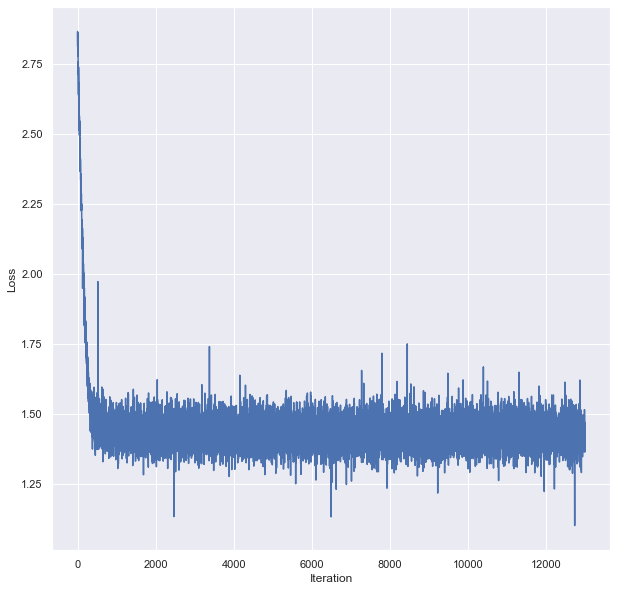

In [29]:
fig = plt.figure(figsize=(10, 10))
sns.lineplot(x = loss['Iteration'], y = loss['Loss'])

In [30]:
avg_loss = pd.DataFrame(avg_loss, columns = ['Loss','Iteration'])
avg_loss.head()

,Loss,Iteration
0,2.451396,0
1,1.836214,1
2,1.539527,2
3,1.465814,3
4,1.450204,4


<AxesSubplot:xlabel='Iteration', ylabel='Loss'>

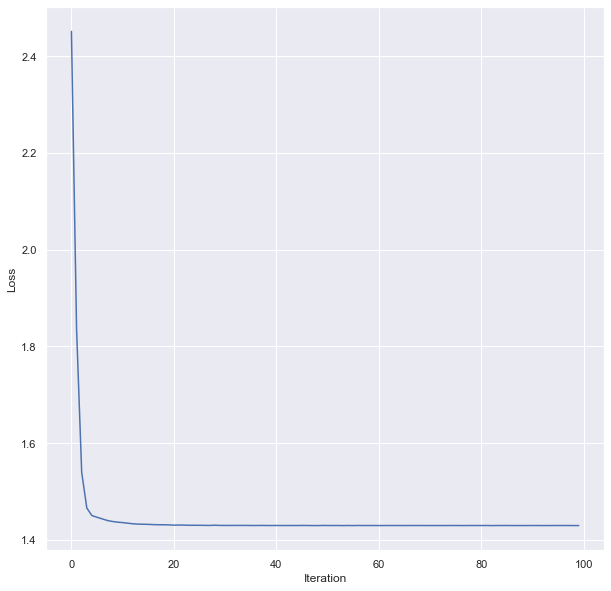

In [31]:
fig = plt.figure(figsize=(10, 10))
sns.lineplot(x = avg_loss['Iteration'], y = avg_loss['Loss'])

In [32]:
import seaborn as sns
import pandas as pd

latents = []

for i in range(len(myDs)):
    sample_idx = torch.randint(len(myDs), size=(1,)).item()
    img, label = myDs[sample_idx]
    img = Variable(img)
    if torch.cuda.is_available():
        img = img.cuda()    

    output,mu,logvar = model(img)
    latent = model.reparametrize(mu, logvar)

    latents.append(np.append(latent.cpu().detach().numpy(),label))

latarray = np.stack(latents, axis=0 )
df_latent = pd.DataFrame(data=latarray, columns=("x1", "x2", "label"))
df_latent["label"] = df_latent["label"].astype(int)
# df_latent
# sns.FacetGrid(df_latent, hue="label", height=6).map(plt.scatter, 'x1', 'x2', 'x3').add_legend()
# plt.savefig("latent_space.png",transparent=True)
# plt.show()


In [33]:
principalDf = df_latent.drop(columns={'label'})
principalDf

,x1,x2
0,0.630948,-0.195110
1,0.776803,0.231558
2,1.566608,-0.288486
3,-0.318120,-1.455188
4,-1.164472,-1.169566
...,...,...
16521,0.585466,-0.368384
16522,-0.257142,0.049684
16523,-0.892503,-0.786949
16524,-0.750344,0.143821


In [34]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

In [35]:
clf = DBSCAN(eps=0.1, min_samples=20).fit(principalDf)

In [36]:
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("\nClusters discovered: %d" % n_clusters_)


Clusters discovered: 5


In [37]:
labelsDf = pd.DataFrame(labels, columns = ['Label'])
labelsDf.head()

,Label
0,0
1,0
2,0
3,0
4,0


In [38]:
labelsDf['Label'].unique()

array([ 0, -1,  4,  2,  1,  3], dtype=int64)

In [39]:
labelsDf.loc[labelsDf["Label"] == -1, "Label"] = 5

In [41]:
labelsDf.head(5)

,Label
0,0
1,0
2,0
3,0
4,0


In [42]:
final = principalDf.join(labelsDf)
final.head(5)

,x1,x2,Label
0,0.630948,-0.195110,0
1,0.776803,0.231558,0
2,1.566608,-0.288486,0
3,-0.318120,-1.455188,0
4,-1.164472,-1.169566,0


In [46]:
len(final)

16526

In [47]:
len(df2)

18849

In [64]:
final.sort_values(by=['Label'])
final.head(5)

,x1,x2,Label
0,0.630948,-0.195110,0
1,0.776803,0.231558,0
2,1.566608,-0.288486,0
3,-0.318120,-1.455188,0
4,-1.164472,-1.169566,0


In [66]:
len(final)

16526

In [87]:
final.to_csv('data/superset/clusters.csv', index=False)

In [65]:
len(df_3)

18842

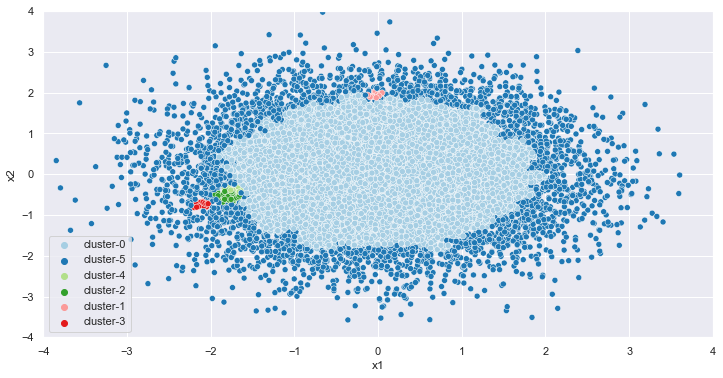

In [76]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(final['x1'], final['x2'], hue=["cluster-{}".format(x) for x in final['Label']], palette="Paired")
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.savefig("charts/dbscan/VAE_consumer.png", bbox_inches='tight')
plt.show()

In [77]:
principalDf = principalDf.join(labelsDf)

In [78]:
len(principalDf)

16526

In [80]:
principalDf.head(5)

,x1,x2,Label
0,0.630948,-0.195110,0
1,0.776803,0.231558,0
2,1.566608,-0.288486,0
3,-0.318120,-1.455188,0
4,-1.164472,-1.169566,0


In [81]:
consumer_types = pd.read_csv('data/consumer_types.csv', low_memory=False)
consumer_types.head()

,Consumer_type,Name
0,1,DOMÉSTICO
1,2,COM/INDUSTRIAL/OBRAS
2,3,UTIL.PUBLICA
3,4,OBRAS
4,5,ESTADO


In [82]:
resultDf = pd.merge(principalDf, df_final['Consumer_type'], left_index=True, right_index=True, how='inner')
resultDf = resultDf.drop(columns=['x1', 'x2'])
print(resultDf.head(5))

   Label  Consumer_type
0      0              3
1      0              1
2      0              1
3      0              2
4      0              1


In [85]:
resultDf.to_csv('data/label_consumer.csv', index=False)

In [83]:
types  = pd.merge(consumer_types, resultDf, left_on='Consumer_type', right_on='Consumer_type', how='inner')
types ['Count'] = types ['Consumer_type']
types.head()

,Consumer_type,Name,Label,Count
0,1,DOMÉSTICO,0,1
1,1,DOMÉSTICO,0,1
2,1,DOMÉSTICO,0,1
3,1,DOMÉSTICO,0,1
4,1,DOMÉSTICO,0,1


In [106]:
df_final = types.groupby(['Label','Name', 'Consumer_type'], as_index=False).agg({'Count':'count'})
df_final.loc[df_final["Label"] == -1, "Label"] = 8
df_final = df_final.rename(columns={'Label': 'Cluster'}).drop(columns=['Consumer_type'])
df_final.head()

,Cluster,Name,Count
0,0,COM/INDUSTRIAL/OBRAS,681
1,0,COM./RURAL A.S,6
2,0,CP.DOM/URB,36
3,0,DOM./RURAL A.S,309
4,0,DOMÉSTICO,7755


In [116]:
colors = ['#023047', '#ffb703', '#8ecae6','#f1c0e8', '#f72585', '#006d77', '#7400b8',  '#ef476f', 
          '#757bc8', '#001233', '#00f5d4', '#8ac926', '#ffca3a','#b7094c', '#8338ec', '#ffc6ff', 
          '#70e000', '#0d47a1']

In [117]:
df_pivot = pd.pivot(df_final, values='Count', index=['Cluster'], columns=['Name']).fillna(0)
df_pivot = df_pivot.rename_axis(None,axis=1).reset_index()
df_pivot.head()

,Cluster,COM/INDUSTRIAL/OBRAS,COM./RURAL A.S,CP.DOM/URB,DOM./RURAL A.S,DOMÉSTICO,ESTADO,EXP.A.RURAL,FAM.CARENCIADAS,FAM.NUMEROSAS,IGREJAS,IPSS/IGR/RURAL,OBRAS,RURAL DOMÉSTICO,RURAL/ESTADO,UTIL.PUBLICA
0,0,681.0,6.0,36.0,309.0,7755.0,45.0,68.0,48.0,6.0,3.0,17.0,71.0,3141.0,33.0,31.0
1,1,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0
2,2,2.0,0.0,0.0,1.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0
3,3,0.0,0.0,0.0,1.0,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,4,1.0,0.0,0.0,0.0,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0


In [118]:
df_pivot_1 = df_pivot[~df_pivot['Cluster'].isin([0, 5])]
df_pivot_2 = df_pivot[df_pivot.Cluster == 0]
df_pivot_3 = df_pivot.loc[ (df_pivot.Cluster == 5)]

In [123]:
fig, axs = plt.subplots(ncols=3, figsize=(25,6))
df_pivot_2.plot(x = 'Cluster', kind='bar', stacked=True, color=colors, ax=axs[0]).legend().set_visible(False)
df_pivot_1.plot(x = 'Cluster', kind='bar', stacked=True, color=colors, ax=axs[1]).legend().set_visible(False)
df_pivot_3.plot(x = 'Cluster', kind='bar', stacked=True, color=colors, ax=axs[2]).legend(bbox_to_anchor=(1.05, 1))
 
fig.suptitle('Count of different consumers')
# plt.gca().set_aspect('equal', adjustable='box') 
plt.savefig("charts/dbscan/VAE_profile_consumer.png", bbox_inches='tight')
plt.show()

# Rotated chart

In [87]:
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt
# from matplotlib import cm
# from matplotlib.ticker import LinearLocator, FormatStrFormatter
# %matplotlib qt

fig = plt.figure(figsize=(20, 20))
ax = fig.gca(projection='3d')

x = np.array(principalDf['x1'])
y = np.array(principalDf['x2'])
z = np.array(principalDf['x3'])

ax.scatter(x,y,z, marker="s", c=principalDf["Label"], s=40, cmap="hsv")
# Customize the z axis.
ax.set_zlim(0, 100)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# rotate the axes and update
for angle in range(0, 360):
    ax.view_init(30, 40)

plt.show()